Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


Laddar data från C:/mnist_data/mnist_augmented_boosted.joblib...
n=65: Accuracy = 0.98517 (Tid: 23.9s)


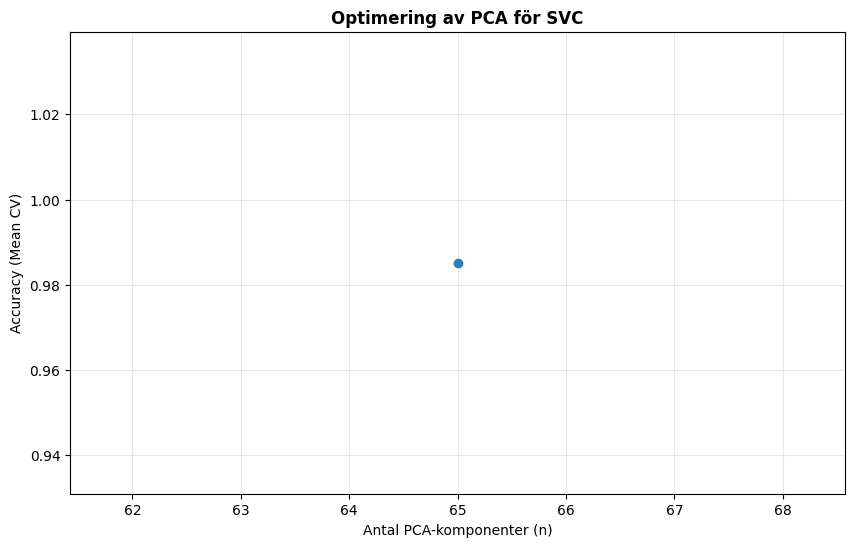

In [8]:
import time
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog

# Boosta prestandan
from sklearnex import patch_sklearn
patch_sklearn()

class HogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def local_hog(img_flat):
            return hog(img_flat.reshape(28, 28), 
                       orientations=self.orientations, 
                       pixels_per_cell=self.pixels_per_cell, 
                       cells_per_block=self.cells_per_block,
                       visualize=False)
        return np.array([local_hog(x) for x in X])
    
# 1. Ladda data (Använd det rena setet för att optimera din SVC-expert)
load_path = "C:/mnist_data/mnist_augmented_boosted.joblib" 
print(f"Laddar data från {load_path}...")
X_aug, y_aug = joblib.load(load_path)

# 2. Subset för snabbhet (15 000 bilder ger tillförlitlig trend)
subset_size = 40000
indices = np.random.choice(len(y_aug), subset_size, replace=False)
X_subset = X_aug[indices]
y_subset = y_aug[indices]

# 3. Kör testet
components = [65] # Vi la till 180 för säkerhets skull
scores = []

for n in components:
    t_start = time.time()
    test_pipe = Pipeline([
        ('feature', FeatureUnion([
            ('pca', PCA(n_components=n, whiten=True)), 
            ('hog', HogTransformer())
        ])),
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel="rbf", C=25, gamma="scale")) 
    ])
    
    score = cross_val_score(test_pipe, X_subset, y_subset, cv=3, n_jobs=-1).mean()
    scores.append(score)
    print(f"n={n}: Accuracy = {score:.5f} (Tid: {time.time()-t_start:.1f}s)")

# 4. Plotta
plt.figure(figsize=(10, 6))
plt.plot(components, scores, marker="o", color='#2980b9', linewidth=2)
plt.xlabel("Antal PCA-komponenter (n)")
plt.ylabel("Accuracy (Mean CV)")
plt.title("Optimering av PCA för SVC", fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()